# 1.业务背景

摩拜单车，英文名mobike，是由胡玮炜创办的北京摩拜科技有限公司研发的互联网短途出行解决方案，是无桩借还车模式的智能硬件。
人们通过智能手机就能快速租用和归还一辆摩拜单车，用可负担的价格来完成一次几公里的市内骑行。
由于一公里的出行是一个高频的需求场景，所以mobike单车累计了大量的用户基本信息以及骑行的数据，
通过这些数据，能够帮助企业更好识别自己的客群画像和他们的骑行偏好。

- 使用Python建立聚类分析模型
- 对于聚类分析模型得出的分群特征进行解读

# 2.数据导入

In [1]:
#调库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#导入数据
mb = pd.read_csv('E:\小灶数据分析课程\第八周\week4.mobike.csv')

In [3]:
#数据类型以及是否有缺失值查看
mb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6427 entries, 0 to 6426
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6427 non-null   int64  
 1   user_id            6427 non-null   int64  
 2   start_time         6427 non-null   object 
 3   end_time           6427 non-null   object 
 4   timeduration       6427 non-null   int64  
 5   bikeid             6427 non-null   int64  
 6   tripduration       6427 non-null   int64  
 7   from_station_id    6427 non-null   int64  
 8   from_station_name  6427 non-null   object 
 9   to_station_id      6427 non-null   int64  
 10  to_station_name    6427 non-null   object 
 11  usertype           6427 non-null   object 
 12  gender             5938 non-null   object 
 13  birthyear          5956 non-null   float64
 14  age                6427 non-null   object 
dtypes: float64(1), int64(7), object(7)
memory usage: 753.3+ KB


- 多了一列Unnamed: 0，需要用describe查看是否需要删除
- user_id应该是object类型，不是数值型数据
- start_time和end_time数据类型应为日期timedate64，且加上timeduration有冗余，可删除start or end_time
- from_station_id和from_station_name都是代表起始点，to_station_id和to_station_name都是代表终点，冗余，应各删除一项（这里考虑删除地名）
- gender有缺失值，视情况选择是填充还是直接删除
- birthyear有缺失值，切数据类型为浮点型，但出生年份应为整数int类型；但age和birthyear可互相转换，因此可直接删除birthyear，但age应该是数值型数据，这里数据类型错误

In [4]:
#数据概览
mb.head(10)

,Unnamed: 0,user_id,start_time,end_time,timeduration,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
0,439283,21499218,11/14/2018 7:37,11/14/2018 7:44,7,2631,436,319,Greenview Ave & Diversey Pkwy,67,Sheffield Ave & Fullerton Ave,Subscriber,Male,1982.0,37
1,603317,21694389,12/18/2018 19:02,12/18/2018 19:10,7,1565,445,164,Franklin St & Lake St,195,Columbus Dr & Randolph St,Subscriber,Male,1988.0,31
2,109957,21110722,10/9/2018 12:37,10/9/2018 12:55,18,2231,1090,163,Damen Ave & Clybourn Ave,69,Damen Ave & Pierce Ave,Customer,Male,1989.0,30
3,428082,21485409,11/12/2018 12:30,11/12/2018 12:40,9,4226,581,226,Racine Ave & Belmont Ave,308,Seeley Ave & Roscoe St,Subscriber,Female,1989.0,30
4,395437,21445994,11/7/2018 7:29,11/7/2018 7:35,6,3475,390,77,Clinton St & Madison St,621,Aberdeen St & Randolph St,Subscriber,Male,1979.0,40
5,73632,21068843,10/6/2018 12:04,10/6/2018 12:17,12,2173,772,321,Wabash Ave & 9th St,134,Peoria St & Jackson Blvd,Subscriber,Male,1994.0,25
6,317778,21354901,10/29/2018 17:26,10/29/2018 17:35,8,1735,505,90,Millennium Park,255,Indiana Ave & Roosevelt Rd,Subscriber,Female,1971.0,48
7,371796,21417733,11/3/2018 16:32,11/3/2018 16:54,22,983,1347,31,Franklin St & Chicago Ave,315,Elston Ave & Wabansia Ave,Customer,NaN,NaN,
8,333577,21373047,10/31/2018 6:15,10/31/2018 6:29,13,2178,819,77,Clinton St & Madison St,331,Halsted St & Clybourn Ave (*),Subscriber,Male,1991.0,28
9,261523,21288683,10/23/2018 18:11,10/23/2018 18:14,3,3888,225,74,Kingsbury St & Erie St,84,Milwaukee Ave & Grand Ave,Subscriber,Male,1989.0,30


In [5]:
#Unnamed: 0是每一行数据对应的行为编码，可以作为索引
mb = pd.read_csv('E:\小灶数据分析课程\第八周\week4.mobike.csv',index_col=0)
mb.head()

,user_id,start_time,end_time,timeduration,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
439283,21499218,11/14/2018 7:37,11/14/2018 7:44,7,2631,436,319,Greenview Ave & Diversey Pkwy,67,Sheffield Ave & Fullerton Ave,Subscriber,Male,1982.0,37
603317,21694389,12/18/2018 19:02,12/18/2018 19:10,7,1565,445,164,Franklin St & Lake St,195,Columbus Dr & Randolph St,Subscriber,Male,1988.0,31
109957,21110722,10/9/2018 12:37,10/9/2018 12:55,18,2231,1090,163,Damen Ave & Clybourn Ave,69,Damen Ave & Pierce Ave,Customer,Male,1989.0,30
428082,21485409,11/12/2018 12:30,11/12/2018 12:40,9,4226,581,226,Racine Ave & Belmont Ave,308,Seeley Ave & Roscoe St,Subscriber,Female,1989.0,30
395437,21445994,11/7/2018 7:29,11/7/2018 7:35,6,3475,390,77,Clinton St & Madison St,621,Aberdeen St & Randolph St,Subscriber,Male,1979.0,40


# 3.数据处理

## 3.1数值型数据处理

In [6]:
mb.describe()

,user_id,timeduration,bikeid,tripduration,from_station_id,to_station_id,birthyear
count,6.427000e+03,6427.000000,6427.000000,6.427000e+03,6427.000000,6427.000000,5956.000000
mean,2.135519e+07,11.778902,3491.637934,1.060471e+03,195.038432,198.502567,1982.488583
std,2.181294e+05,9.692236,1912.171846,1.456811e+04,148.170025,148.939873,11.147859
min,2.098358e+07,0.000000,2.000000,6.100000e+01,2.000000,2.000000,1906.000000
25%,2.116805e+07,5.000000,1852.000000,3.490000e+02,77.000000,80.000000,1977.000000
50%,2.135114e+07,9.000000,3618.000000,5.590000e+02,168.000000,172.000000,1986.000000
75%,2.154376e+07,15.000000,5179.500000,9.320000e+02,287.000000,287.000000,1991.000000
max,2.174223e+07,59.000000,6470.000000,1.139070e+06,662.000000,661.000000,2002.000000


In [7]:
sum(mb.duplicated())

0

- user_id,from_station_id,to_station_id，bikeid都应该是object类型
- birthyear应该是int整数型数据

In [8]:
#更改数据类型
mb['user_id'] = mb['user_id'].astype(str)
mb['bikeid'] = mb['bikeid'].astype(str)

In [9]:
mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6427 entries, 439283 to 278179
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            6427 non-null   object 
 1   start_time         6427 non-null   object 
 2   end_time           6427 non-null   object 
 3   timeduration       6427 non-null   int64  
 4   bikeid             6427 non-null   object 
 5   tripduration       6427 non-null   int64  
 6   from_station_id    6427 non-null   int64  
 7   from_station_name  6427 non-null   object 
 8   to_station_id      6427 non-null   int64  
 9   to_station_name    6427 non-null   object 
 10  usertype           6427 non-null   object 
 11  gender             5938 non-null   object 
 12  birthyear          5956 non-null   float64
 13  age                6427 non-null   object 
dtypes: float64(1), int64(4), object(9)
memory usage: 753.2+ KB


### 3.1.1user_id

In [10]:
mb.user_id.nunique()

6427

- user_id 6427个，正好和样本数据一致，因为没有重复的id，和索引id功能一致，因此可以直接删除

In [11]:
mb=mb.drop(['user_id'],axis=1)

### 3.1.2timeduration

In [12]:
mb['timeduration'].describe()

count    6427.000000
mean       11.778902
std         9.692236
min         0.000000
25%         5.000000
50%         9.000000
75%        15.000000
max        59.000000
Name: timeduration, dtype: float64

In [13]:
mb[mb['timeduration']<1]
#timeduration为0的仅有五个，按照end_time减去start_time计算，发现都是1小时或者1小时一分钟，可重置为60分钟

,start_time,end_time,timeduration,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
109113,10/9/2018 11:29,10/9/2018 12:29,0,4875,3616,225,Halsted St & Dickens Ave,172,Rush St & Cedar St,Customer,NaN,NaN,
72232,10/6/2018 10:15,10/6/2018 11:15,0,4733,3606,419,Lake Park Ave & 53rd St,76,Lake Shore Dr & Monroe St,Customer,NaN,NaN,
69595,10/5/2018 18:27,10/5/2018 19:28,0,2064,3650,50,Clark St & Congress Pkwy,283,LaSalle St & Jackson Blvd,Customer,Male,1989.0,30
302629,10/27/2018 15:33,10/27/2018 16:34,0,5051,3634,3,Shedd Aquarium,199,Wabash Ave & Grand Ave,Customer,NaN,NaN,
592619,12/17/2018 9:17,12/17/2018 10:18,0,4316,3652,99,Lake Shore Dr & Ohio St,96,Desplaines St & Randolph St,Subscriber,Male,1988.0,31


In [14]:
mb['timeduration'] = mb['timeduration'].replace(0,60)

### 3.1.3bikeid

- 目标任务是对客户进行分群，那么bikeid是无用变量，直接删除就行

In [15]:
mb=mb.drop(['bikeid'],axis=1)

### 3.1.4tripduration

In [16]:
mb['tripduration'].describe()

count    6.427000e+03
mean     1.060471e+03
std      1.456811e+04
min      6.100000e+01
25%      3.490000e+02
50%      5.590000e+02
75%      9.320000e+02
max      1.139070e+06
Name: tripduration, dtype: float64

In [17]:
#先转换数据类型为int整数型
mb['tripduration'] = mb['tripduration'].astype(int)

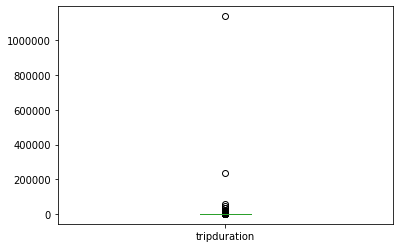

In [18]:
#可视化查看数据分布
mb['tripduration'].plot(kind='box')
# 可以看出，tripduration有异常值存在，1小时内能骑到1000000米。。因此需要删除离群值

In [19]:
mb['tripduration'].quantile(.75)

932.0

In [20]:
#找出最大值
IQR=mb['tripduration'].quantile(.75)-mb['tripduration'].quantile(.25)
MAX=mb['tripduration'].quantile(.75)+ 1.5* IQR
print(MAX)

1806.5


In [21]:
#最大值为1806.5米，删除大于最大值的部分
mb=mb[mb['tripduration']<=1806.5]

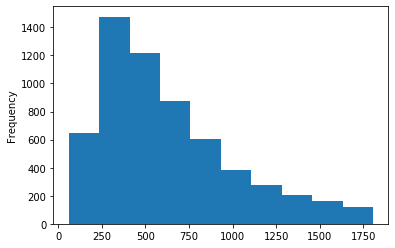

In [22]:
mb['tripduration'].plot(kind='hist')

### 3.1.5age

In [23]:
#年龄应该为数值型数据，先更改数据类型
mb['age']= mb['age'].astype(int)

ValueError: invalid literal for int() with base 10: ' '

In [24]:
#报错显示存在空白值，需要进行填充，首先看是否可通过birthyear进行转化
mb.age.unique()

array(['37', '31', '30', '40', '25', '48', ' ', '28', '27', '34', '33',
       '26', '20', '23', '22', '54', '52', '57', '29', '39', '51', '55',
       '32', '49', '58', '42', '61', '35', '41', '63', '50', '38', '36',
       '43', '44', '19', '59', '45', '46', '56', '21', '24', '47', '66',
       '64', '62', '77', '69', '60', '68', '70', '53', '113', '73', '18',
       '67', '65', '71', '79', '17', '74', '72', '101'], dtype=object)

In [25]:
mb[mb['age']==' ']['birthyear'].unique()
#年龄为空白的数据出生年份也为空值

array([nan])

In [26]:
(mb[mb['age']==' '].index== mb[mb.birthyear.isna()].index).all()
#利用索引查看是否age空白的和birthyear缺失值的数据完全一致，结果是完全一致的

True

In [27]:
mb.birthyear.isna().sum()
#birthyear和age有292个空缺值，292/6427占比0.045，用中位数或者均值填充比较好

292

In [28]:
age_median = int(mb[mb['age']!=' ']['age'].astype(int).median())
print(age_median)

33


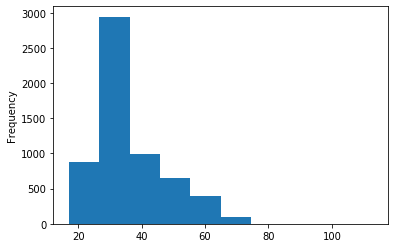

In [29]:
#先试试用中位数填充
mb.age.str.replace(' ',str(age_median)).astype(int).plot(kind='hist')

In [30]:
age_mean = int(mb[mb['age']!=' ']['age'].astype(int).mean())
print(age_mean)

36


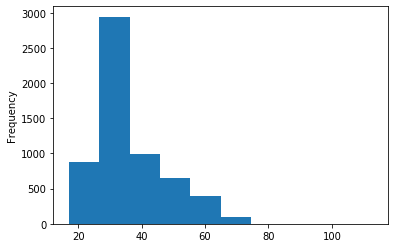

In [31]:
#再试试用均值填充
mb.age.str.replace(' ',str(age_mean)).astype(int).plot(kind='hist')

In [32]:
#数据整体偏均值右侧，因此为数据调整正态分布，选择中位数填充
mb['age'] = mb.age.str.replace(' ',str(age_median)).astype(int)
#数据中有年龄过大的，超过80再骑车就有点奇怪，就算可能有也是少数不是我们关注的重点对象，因此需要进行离群值处理

In [33]:
IQR1=mb['age'].quantile(.75)-mb['age'].quantile(.25)
MAX1=mb['age'].quantile(.75)+ 1.5* IQR1
print(MAX1)

63.0


In [34]:
mb=mb[mb['age']<=63]

In [35]:
mb['age']=mb['age'].astype(int)
mb['age'].describe()

count    5853.000000
mean       35.683752
std         9.970922
min        17.000000
25%        28.000000
50%        33.000000
75%        41.000000
max        63.000000
Name: age, dtype: float64

### 3.1.6birthyear

- age已处理完成，birthyear没有意义可直接删除

In [36]:
mb=mb.drop(['birthyear'],axis=1)

## 3.2分类型数据处理

### 3.2.1usertype

In [37]:
mb['usertype'].value_counts()
#客户分为两类，大部分都是订阅者，有利于客户忠诚度以及留存
mb['usertype']=mb['usertype'].astype(object)

### 3.2.2from_station_name和to_station_name

- 两者都与Id重复，直接删除

In [38]:
mb=mb.drop(['from_station_name'],axis=1)
mb=mb.drop(['to_station_name'],axis=1)

### 3.2.3gender

In [39]:
mb.gender.unique()
#其中存在空值，需进行填充

array(['Male', 'Female', nan], dtype=object)

In [40]:
mb['gender'] = mb['gender'].fillna('Unknown')

## 3.3 日期型数据处理

### 3.3.1start_time

- 首先需要把变量转化为日期型数据

In [41]:
mb['start_time']= pd.to_datetime(mb['start_time'])

In [42]:
mb['start_time'].dt.year.unique()
#数据都是2018年的

array([2018], dtype=int64)

In [43]:
mb['start_time'].dt.month.unique()
#数据分布于10,11,12三个月份

array([11, 12, 10], dtype=int64)

### 3.3.2end_time

- 有了开始时间和持续时间，结束时间多余，直接删除

In [44]:
mb=mb.drop(['end_time'],axis=1)

In [45]:
#结束数据处理，概览查看
mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5853 entries, 439283 to 278179
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   start_time       5853 non-null   datetime64[ns]
 1   timeduration     5853 non-null   int64         
 2   tripduration     5853 non-null   int32         
 3   from_station_id  5853 non-null   int64         
 4   to_station_id    5853 non-null   int64         
 5   usertype         5853 non-null   object        
 6   gender           5853 non-null   object        
 7   age              5853 non-null   int32         
dtypes: datetime64[ns](1), int32(2), int64(3), object(2)
memory usage: 365.8+ KB


# 4可视化分析

## 4.1单变量分析

### 4.1.1timeduration

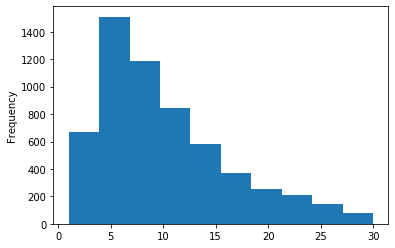

In [46]:
mb['timeduration'].plot(kind='hist');
#可以看出最常见的骑行时长集中在5-10分钟的较短时长，超过15分钟的占比都较少

### 4.1.2tripduration

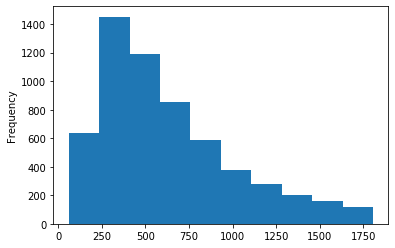

In [47]:
mb['tripduration'].plot(kind='hist');
#骑行距离的分布图与骑行时长很像，250m-520m左右是最常见的骑行距离，超过1000m的都较少

### 4.1.3age

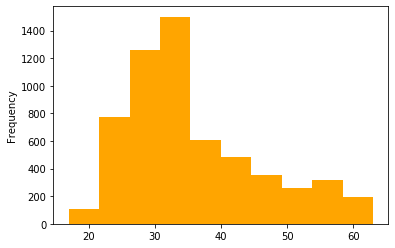

In [48]:
mb['age'].plot(kind='hist',color='orange');
#年龄在22-35之间的客户使用摩拜骑行的最多

### 4.1.4usertype

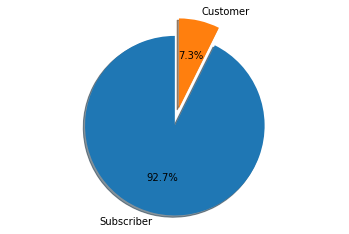

In [49]:
labels = 'Subscriber', 'Customer'
explode = (0.2, 0)  #设置‘Customer’凸显，间距为0.2
fig1, ax1 = plt.subplots()
ax1.pie(mb['usertype'].value_counts(),explode=explode,labels=labels,autopct='%1.1f%%',shadow=True, startangle=90)#autopct对输出进行格式化，startangle为起始角度，一般设置为90比较好看
ax1.axis('equal');#保证为正圆

- 92.7%都是订阅者，有利于客户的留存，即下次使用

### 4.1.5gender

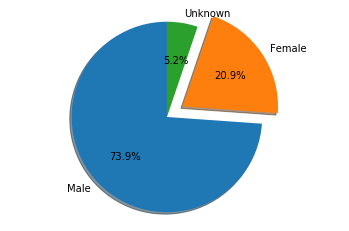

In [50]:
labels = 'Male', 'Female','Unknown'
explode = (0, 0.2, 0)  #设置‘Female’凸显，间距为0.2
fig1, ax1 = plt.subplots()
ax1.pie(mb['gender'].value_counts(),explode=explode,labels=labels,autopct='%1.1f%%',shadow=True, startangle=90)#autopct对输出进行格式化，startangle为起始角度，一般设置为90比较好看
ax1.axis('equal');#保证为正圆

### 4.1.6start_time

In [51]:
#先根据start_time生成有用的时间变量
mb['month'] = mb['start_time'].dt.month
mb['dayofweek'] = mb['start_time'].dt.dayofweek
mb['hour'] = mb['start_time'].dt.hour

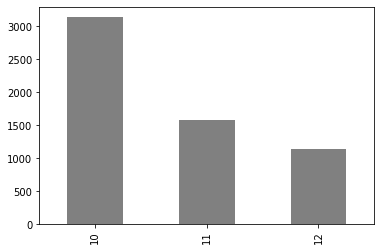

In [52]:
mb['month'].value_counts().sort_index().plot(kind='bar',color='grey');

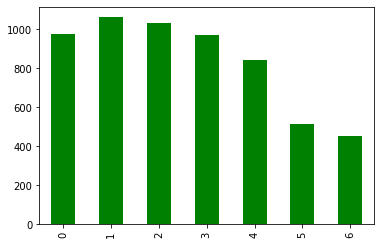

In [53]:
mb['dayofweek'].value_counts().sort_index().plot(kind='bar',color='green')

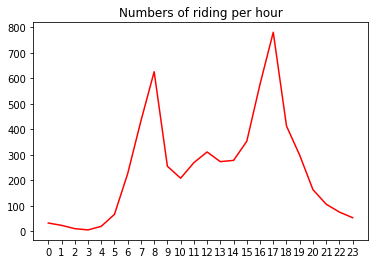

In [54]:
a=mb.hour.unique()
b=np.sort(a)
mb['hour'].value_counts().sort_index().plot(kind='line',color='red',title='Numbers of riding per hour');
order=list(b)
plt.xticks(np.arange(len(order)),order);

- 从时间来看，其中10月份骑行次数最多，12月最少，可能与天气变冷有关也可能与假期有关，需进一步探讨
- 工作日周一到周日的骑行次数最多，而周末有所减少
- 从时间段来看，集中在早高峰晚高峰的骑行人数最多，上午7.8时，下午16.17.18时，摩拜需保证单车充足的供应量

## 4.2 多变量分析

In [55]:
tmp = pd.DataFrame(mb.groupby(['dayofweek','gender'])['hour'].count()).reset_index()

In [56]:
tmp = tmp.rename(columns={'hour':'count'})

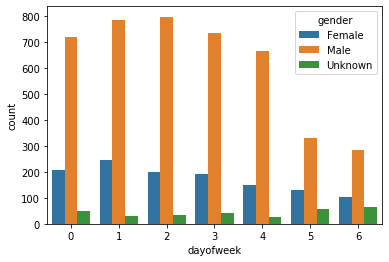

In [57]:
sns.barplot(x='dayofweek',hue='gender',y='count',data=tmp);

- 男性女性都是工作日骑行人数多于周末，但Unknown确实周末骑行人数多于工作日

# 5建模

In [58]:
#调包
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [59]:
mb.head()

,start_time,timeduration,tripduration,from_station_id,to_station_id,usertype,gender,age,month,dayofweek,hour
439283,2018-11-14 07:37:00,7,436,319,67,Subscriber,Male,37,11,2,7
603317,2018-12-18 19:02:00,7,445,164,195,Subscriber,Male,31,12,1,19
109957,2018-10-09 12:37:00,18,1090,163,69,Customer,Male,30,10,1,12
428082,2018-11-12 12:30:00,9,581,226,308,Subscriber,Female,30,11,0,12
395437,2018-11-07 07:29:00,6,390,77,621,Subscriber,Male,40,11,2,7


In [60]:
mb= mb.drop(['from_station_id','to_station_id','start_time'],axis=1)

In [61]:
#转换哑变量
mb1 = pd.get_dummies(mb,drop_first=True)

In [62]:
mb1.head()

,timeduration,tripduration,age,month,dayofweek,hour,usertype_Subscriber,gender_Male,gender_Unknown
439283,7,436,37,11,2,7,1,1,0
603317,7,445,31,12,1,19,1,1,0
109957,18,1090,30,10,1,12,0,1,0
428082,9,581,30,11,0,12,1,0,0
395437,6,390,40,11,2,7,1,1,0


In [63]:
scores = []
centers = list(range(2,15))

for center in centers:
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(mb1)
    label = model.predict(mb1)
    score = silhouette_score(mb1,label)#,sample_size=4000
    scores.append(score)


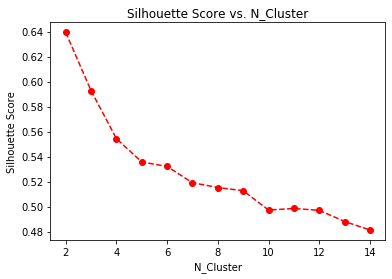

In [64]:
plt.plot(centers, scores, linestyle='--', marker='o', color='red');
plt.xlabel('N_Cluster');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs. N_Cluster');

## 6.优化

In [80]:
mb2= mb

In [81]:
#将年龄，骑行时间，骑行距离等分组
bins=[0,30,50,63]
labels=['<30','30-50','>50']
mb2['age']=pd.cut(mb2.age, bins, right=True,labels=labels)
mb2['age'].value_counts(1)

30-50    0.519050
<30      0.365112
>50      0.115838
Name: age, dtype: float64

In [82]:
bins=[0,5,10,15,60]
labels=['<5','5-10','10-15','>15']
mb2['timeduration']=pd.cut(mb2.timeduration, bins, right=True,labels=labels)
mb2['timeduration'].value_counts(1)

5-10     0.345122
<5       0.285836
10-15    0.188109
>15      0.180933
Name: timeduration, dtype: float64

In [83]:
bins=[0,250,500,1000,1806]
labels=['<250','250-500','500-1000','>1000']
mb2['tripduration']=pd.cut(mb2.tripduration, bins, right=True,labels=labels)
mb2['tripduration'].value_counts(1)

500-1000    0.362549
250-500     0.343584
>1000       0.162652
<250        0.131215
Name: tripduration, dtype: float64

In [84]:
#转换哑变量
mb2 = pd.get_dummies(mb2,drop_first=True)

In [85]:
mb2.head()

,month,dayofweek,hour,timeduration_5-10,timeduration_10-15,timeduration_>15,tripduration_250-500,tripduration_500-1000,tripduration_>1000,usertype_Subscriber,gender_Male,gender_Unknown,age_30-50,age_>50
439283,11,2,7,1,0,0,1,0,0,1,1,0,1,0
603317,12,1,19,1,0,0,1,0,0,1,1,0,1,0
109957,10,1,12,0,0,1,0,0,1,0,1,0,0,0
428082,11,0,12,1,0,0,0,1,0,1,0,0,0,0
395437,11,2,7,1,0,0,1,0,0,1,1,0,1,0


In [86]:
scores = []
centers = list(range(2,10))

for center in centers:
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(mb2)
    label = model.predict(mb2)
    score = silhouette_score(mb2,label)#,sample_size=4000
    scores.append(score)

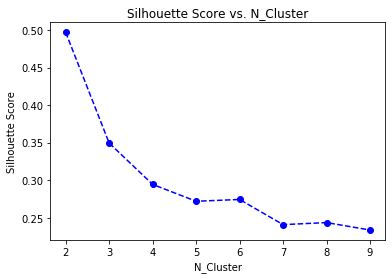

In [87]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('N_Cluster');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs. N_Cluster');

In [65]:
#将timeduration的离群值处理
mb3= mb.drop(['hour','month'],axis=1)

In [66]:
IQR2=mb3['timeduration'].quantile(.75)-mb3['timeduration'].quantile(.25)
MAX2=mb3['timeduration'].quantile(.75)+ 1.5* IQR2
print(MAX2)

25.0


In [67]:
mb3=mb3[mb3['timeduration']<25]

In [68]:
mb3 = pd.get_dummies(mb3,drop_first=True)

In [69]:
mb3.head()

,timeduration,tripduration,age,dayofweek,usertype_Subscriber,gender_Male,gender_Unknown
439283,7,436,37,2,1,1,0
603317,7,445,31,1,1,1,0
109957,18,1090,30,1,0,1,0
428082,9,581,30,0,1,0,0
395437,6,390,40,2,1,1,0


In [70]:
scores = []
centers = list(range(2,10))

for center in centers:
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(mb3)
    label = model.predict(mb3)
    score = silhouette_score(mb3,label)#,sample_size=4000
    scores.append(score)

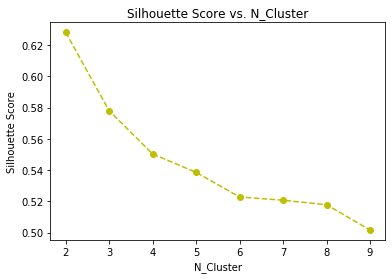

In [71]:
plt.plot(centers, scores, linestyle='--', marker='o', color='y');
plt.xlabel('N_Cluster');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs. N_Cluster');
#评分变低，效果变差，不取

In [72]:
mb4=pd.get_dummies(mb)

In [73]:
mb4.head()

,timeduration,tripduration,age,month,dayofweek,hour,usertype_Customer,usertype_Subscriber,gender_Female,gender_Male,gender_Unknown
439283,7,436,37,11,2,7,0,1,0,1,0
603317,7,445,31,12,1,19,0,1,0,1,0
109957,18,1090,30,10,1,12,1,0,0,1,0
428082,9,581,30,11,0,12,0,1,1,0,0
395437,6,390,40,11,2,7,0,1,0,1,0


In [74]:
scores = []
centers = list(range(2,10))

for center in centers:
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(mb4)
    label = model.predict(mb4)
    score = silhouette_score(mb4,label)#,sample_size=4000
    scores.append(score)

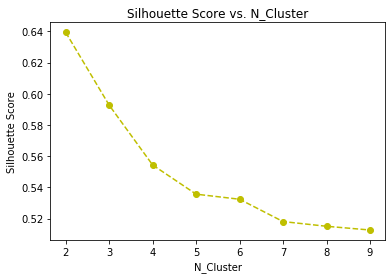

In [75]:
plt.plot(centers, scores, linestyle='--', marker='o', color='y');
plt.xlabel('N_Cluster');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs. N_Cluster');

- 多次尝试优化结果并不理想，决定按照最后一种方式构建模型聚类分析
- 选择3个群集

In [76]:
kmeans_best = KMeans(3)
model_best = kmeans_best.fit(mb4)
labels_best = model_best.predict(mb4)

### 7.业务解读

In [77]:
centers1=pd.DataFrame(model_best.cluster_centers_)

In [78]:
centers1.to_csv('E:\小灶数据分析课程\第八周\centers_3.csv')

- 从excel表得出，分为3个群体，三个群体都聚集于35,36岁，10月份的周二周三以及下午13时左右，区别在于骑行时长，性别，以及是否订阅客户
- 第一个群体0是骑行时间较长距离较远，表现出的特征有：骑行时长平均22.2分钟，平均距离长达1362m，这一群体的未订阅客户远高于其他群体，达到21%，未知性别的客户远高于其他群体。
- 第三个群体2是骑行时间较短距离较短，表现出的特征有：骑行平均时长仅为5.3分钟，平均骑行距离约347m，这一群体的订阅客户远高于其他群体，且男性客户比例多于其他群体。
- 第二个群体1居于上面两个群体中间，骑行平均距离766m，平均用时12分钟。

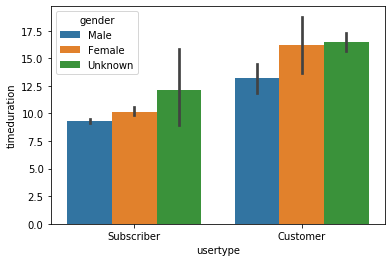

In [79]:
#基于上述分群的结论，想要探索订阅与否客户与骑行时长的关系
sns.barplot(x='usertype',y='timeduration',hue='gender',data=mb)

- 可以看出未订阅客户的平均骑行时长确实大于订阅客户，可能是由于未购买套餐，1.5元的骑行想要尽量发挥到最大用处
- 同时从性别来看，未知性别的客户群体普遍骑行平均时间长于女性客户群体，男性客户群体骑行时间最短